1. Introduction
1. Detecting  of seasonality
1. ARIMA model
1. TBATS model
1. Model accuracy

## 1. Introduction
The goal of this notebook is to show how to tune ARIMA model with additional regressors. We will add some Fourier terms to capture multiple seasonality and compare the best model with TBATS model.

First, we'll  load packages, data set and select only one Wikipedia page with a novel "1984" by George Orwell.

In [1]:
require(data.table)
require(TSA)
require(forecast)

train <- fread("../input/train_1.csv")

x <- unlist(train[Page=="1984_(novela)_es.wikipedia.org_desktop_all-agents", -1])
x <- tsclean(x)

Loading required package: data.table
Loading required package: TSA
Loading required package: leaps
Loading required package: locfit
locfit 1.5-9.1 	 2013-03-22
Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-18. For overview type 'help("mgcv-package")'.
Loading required package: tseries

Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar

Loading required package: forecast

Attaching package: ‘forecast’

The following object is masked from ‘package:nlme’:

    getResponse



Read 145063 rows and 551 (of 551) columns from 0.259 GB file in 00:00:05


## 2. Detecting  of seasonality
We will find seasonality using Fourier Transform. First, we'll check if a given time series is stationary; second, we'll detect the two highest "power" frequencies with a periodogram.

In [2]:
ndiffs(x)

[1] 0

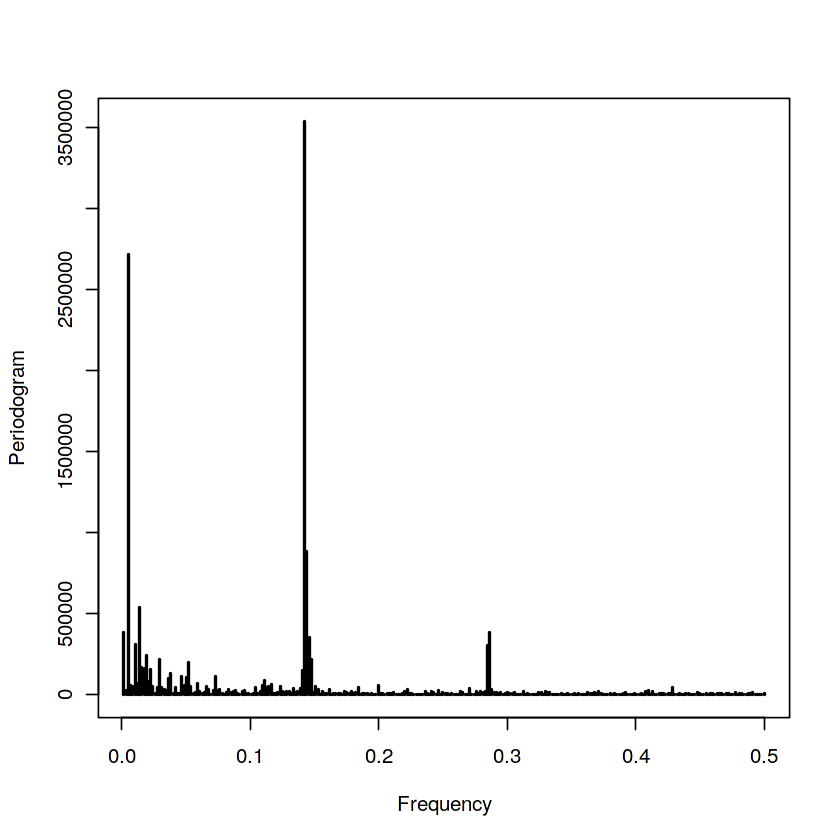

In [3]:
p <- periodogram(x)

In [4]:
data.table(period=1/p$freq, spec=p$spec)[order(-spec)][1:2]

period,spec
7.02439,3535484
192.00000,2715705


## 3. ARIMA model
From the table above we can see that the main seasonality detected is 7.02 days, the second seasonality is 192 days. Thus, we will add two matrices with Fourier terms as external regressors, but first we need to find a maximum order of Fourier terms for each matrix by minimizing AICc.  Also we'll divide out data into train and test sets and build a base model.

In [5]:
# Train set
y <- ts(x[1:490])

# Test set
y.te <- x[491:550]

In [6]:
# Base model
fit0 <- auto.arima(y)
(bestfit <- list(aicc=fit0$aicc, i=0, j=0, fit=fit0))

$aicc
[1] 5854.603

$i
[1] 0

$j
[1] 0

$fit
Series: y 
ARIMA(3,1,2)                    

Coefficients:
         ar1      ar2      ar3      ma1     ma2
      0.9967  -0.6529  -0.1869  -1.3650  0.7081
s.e.  0.0583   0.0641   0.0552   0.0433  0.0359

sigma^2 estimated as 9091:  log likelihood=-2921.21
AIC=5854.43   AICc=5854.6   BIC=5879.58


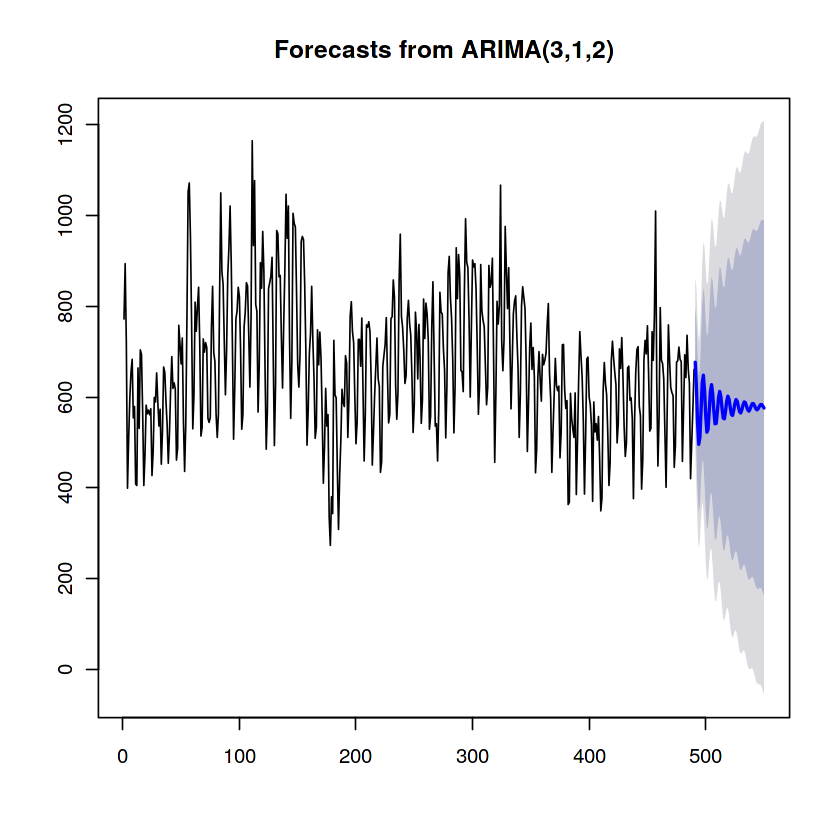

In [7]:
fc0 <- forecast(fit0, h=60)
plot(fc0)

In [8]:
# Choose the best model by AICc
for(i in 1:3) {
  for (j in 1:3){
    z1 <- fourier(ts(y, frequency=7.02), K=i)
    z2 <- fourier(ts(y, frequency=192), K=j)
    fit <- auto.arima(y, xreg=cbind(z1, z2), seasonal=F)
    if(fit$aicc < bestfit$aicc) {
      bestfit <- list(aicc=fit$aicc, i=i, j=j, fit=fit)
    }
  }
}
bestfit

$aicc
[1] 5701.967

$i
[1] 2

$j
[1] 2

$fit
Series: y 
Regression with ARIMA(4,1,4) errors 

Coefficients:
          ar1      ar2      ar3     ar4      ma1     ma2     ma3      ma4
      -0.0835  -0.5217  -0.2859  0.3035  -0.3760  0.2093  0.0240  -0.7816
s.e.   0.1476   0.1210   0.1530  0.1014   0.1333  0.1558  0.1543   0.1310
          S1-7      C1-7     S2-7      C2-7    S1-192    C1-192   S2-192
      -10.9065  121.4833  -1.9156  -40.5546  -48.4409  -78.5648  11.4641
s.e.    6.5901    6.5909   4.8103    4.8177   13.5490   12.5852  11.0201
        C2-192
      -29.1237
s.e.   10.7795

sigma^2 estimated as 6484:  log likelihood=-2833.33
AIC=5700.67   AICc=5701.97   BIC=5771.94


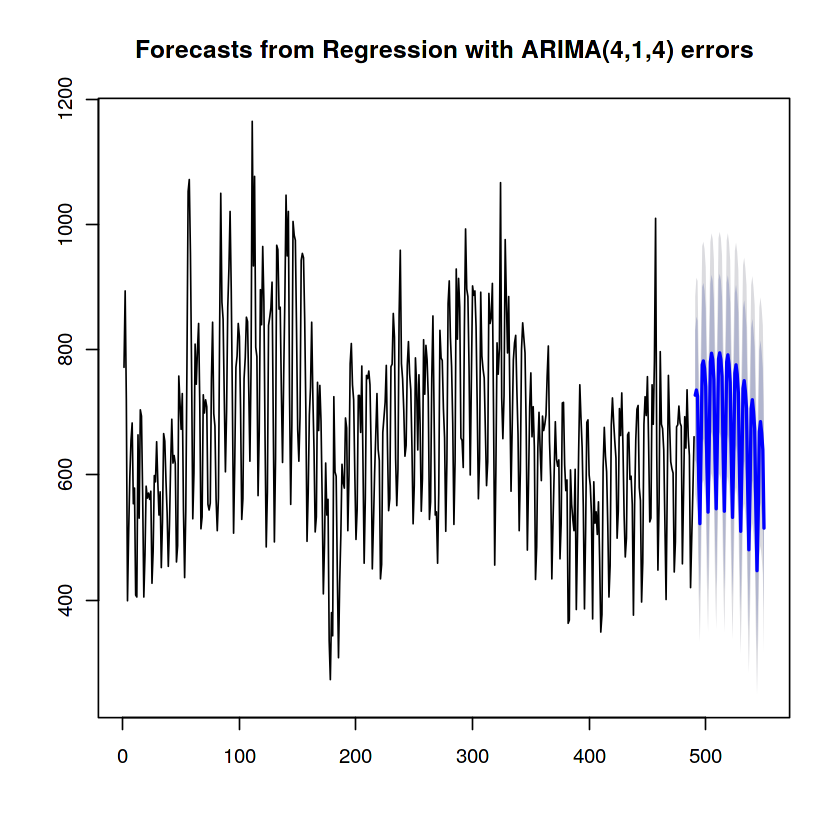

In [9]:
fc <- forecast(bestfit$fit, 
               xreg=cbind(
                 fourier(ts(y, frequency=7.02), K=bestfit$i, h=60),
                 fourier(ts(y, frequency=192), K=bestfit$j, h=60)))
plot(fc)


## 4. TBATS model
[TBATS](https://robjhyndman.com/papers/ComplexSeasonality.pdf) is an exponential smoothing model with Box-Cox transformation, ARMA errors, trend and seasonal components. It tunes its parameters automatically. Very cool model, but it can't use external regressors.

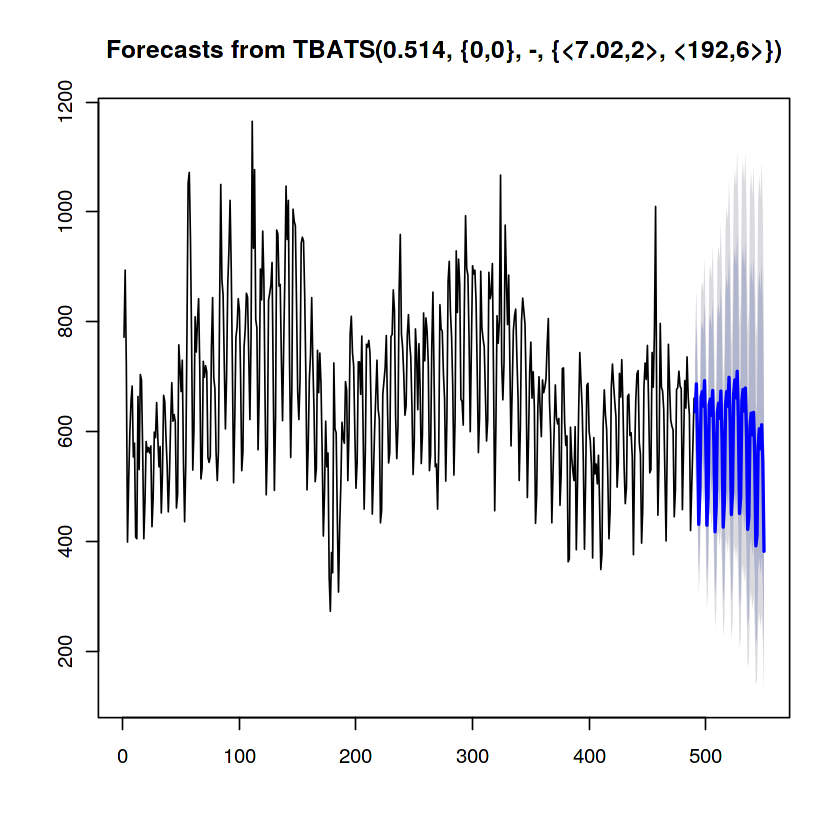

In [10]:
fc.tbats <- forecast(tbats(y, seasonal.periods=c(7.02, 192)), h=60)
plot(fc.tbats)

## 5. Model accuracy
We will use *accuracy()* function from the *forecast* package and a custom SMAPE function to compare models.

In [11]:
accuracy(fc0, y.te)
accuracy(fc, y.te)
accuracy(fc.tbats, y.te)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-0.6227383,94.75894,74.14291,-1.894666,11.71602,0.7267019,-0.04991791
Test set,137.5021932,257.04725,198.65971,10.199495,27.30848,1.9471367,NA


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-4.959912,79.11153,61.29358,-2.234391,9.799773,0.6007608,0.01053627
Test set,43.091885,197.43981,149.98938,-1.647010,22.237834,1.4701010,NA


,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,0.3222253,74.44284,55.99669,-0.9702195,8.672418,0.5488441,0.08554438
Test set,135.0135369,230.04244,177.04468,12.9389365,23.364714,1.7352799,NA


In [12]:
smape <- function(act, fc){
  pred <- as.vector(fc$mean)
  sm <- abs(act - pred) / (abs(act) + abs(pred) + 1e-12)
  200 * mean(sm, na.rm=T)
}
smape(y.te, fc0)
smape(y.te, fc)
smape(y.te, fc.tbats)

[1] 28.96613

[1] 21.73435

[1] 25.96739

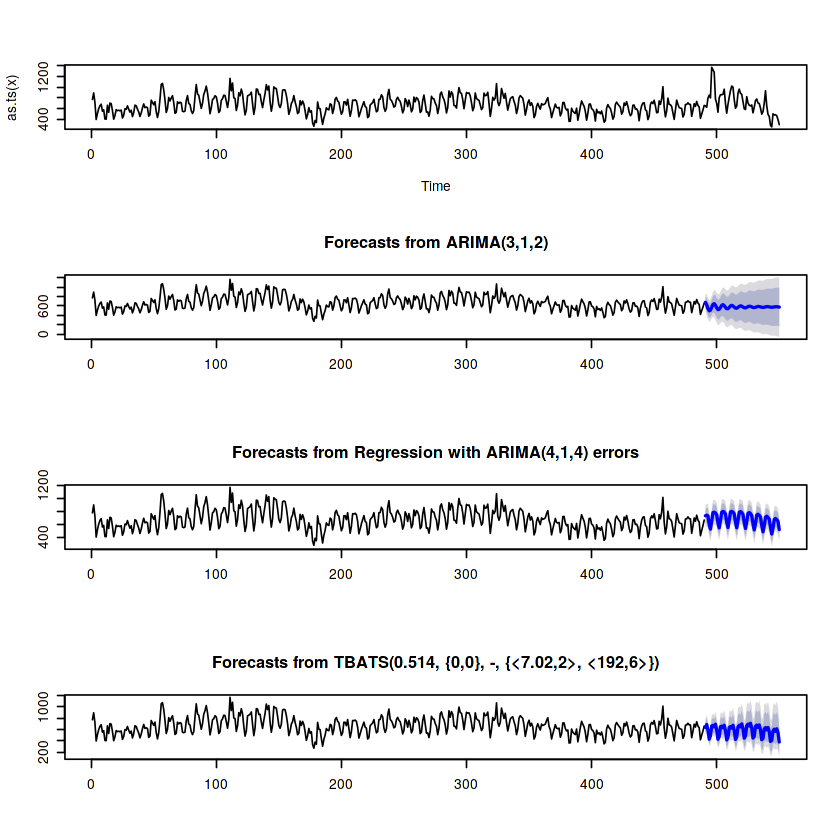

In [13]:
par(mfrow=c(4,1))
plot(as.ts(x))
plot(fc0)
plot(fc)
plot(fc.tbats)

Although this ARIMA model with external regressors performs well for the page of the novel "1984" it can be pretty slow for large orders of Fourier terms. 